“streaming”:

LangGraph execution = a graph of nodes (LLM, tools, routers, memory, etc).

When you run the graph, events happen step-by-step:

LLM generates tokens

Tool is called

Tool returns output

LLM continues

State updates

Streaming lets you observe these events as they happen, instead of waiting for the final answer.

stream_mode="values":

The current state values

Only changed parts of the state

Clean, minimal output

Use when
Chat UI
Streaming final answers
You only care about LLM output
Production APIs

stream_mode="updates" (DEBUG MODE):
Which node updated

What exactly changed

Node-by-node granularity

Use when
Debugging agent behavior
Understanding tool routing
Seeing why something broke
Building observability / tracing

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_tavily import TavilySearch

c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(
c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(


In [2]:
tavily = TavilySearch()
tavily.invoke('current date')

{'query': 'current date',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datetoday.net/',
   'title': "What is the date today? Today's Date",
   'content': 'Today\'s Date is Sat Jan 24 2026. About Date Today. The term "Date Today" refers to the current calendar date as determined by a system\'s internal clock',
   'score': 0.72907686,
   'raw_content': None},
  {'url': 'https://www.rapidtables.com/tools/todays-date.html',
   'title': "Today's Date | Current date now - RapidTables.com",
   'content': "This page includes the following information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds.",
   'score': 0.64639384,
   'raw_content': None},
  {'url': 'https://isotropic.org/date/',
   'title': "Today's Date - isotropic.org",
   'content': 'Today is: ; Gregorian: Sunday, 25 January 2026 ; Mayan: Long count = 13.0.13.5.3; tzolkin = 3 Akbal; haab = 1 Pax ; French: 6 Pluviôse an 234 de la Révolution.',
  

In [3]:
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(doc_content_chars_max=500))

In [4]:
arxiv.run('imporving camera quality using ai')

'Published: 2025-01-06\nTitle: Foundations of GenIR\nAuthors: Qingyao Ai, Jingtao Zhan, Yiqun Liu\nSummary: The chapter discusses the foundational impact of modern generative AI models on information access (IA) systems. In contrast to traditional AI, the large-scale training and superior data modeling of generative AI models enable them to produce high-quality, human-like responses, which brings brand new opportunities for the development of IA paradigms. In this chapter, we identify and introduce '

In [5]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=500))

In [6]:
wikipedia.invoke(' pm of india names')

'Page: Prime Minister of India\nSummary: The prime minister of India (ISO: Bhārat kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times re'

In [7]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [8]:
# Here docstring is important because llm will read this . so give proper desc.

def multiply(a:int,b:int)->int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b


def add(a:int,b:int)->int:
    """
    Adds two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

def divide(a:int,b:int)->int:
    """
    Divides the first integer by the second and returns the result.

    Args:
        a (int): The numerator.
        b (int): The denominator.

    Returns:
        int: The result of dividing a by b.
    """
    return a/b

In [9]:
tools =[add,multiply,divide,wikipedia,arxiv,tavily]

In [ ]:
# from langchain_openai import ChatOpenAI
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

# llm =ChatOpenAI(model="gpt-3.5-turbo")

In [11]:
# # Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [12]:
llm_with_tools =llm.bind_tools(tools=tools)

In [13]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.prebuilt import ToolNode,tools_condition
from typing import Annotated,TypedDict
from IPython.display import Image,display


In [14]:
class State(TypedDict):
    messages :Annotated[list[AnyMessage],add_messages]


In [15]:
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}


In [16]:
builder =StateGraph(State)

builder.add_node('llm_tool',llm_tool)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'llm_tool')
builder.add_conditional_edges('llm_tool',tools_condition) #If the LLM’s answer is sufficient, tools_condition can be written to skip all tools. If the LLM cannot answer confidently or detects a tool is needed (like arxiv for papers, wikipedia for general info), the corresponding tool node is executed.
builder.add_edge('tools','llm_tool') # this is react architecture
builder.add_edge('llm_tool',END)







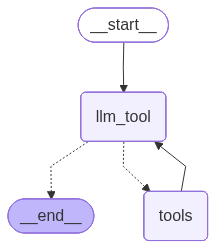

In [17]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [18]:
# Specify the Config 

config ={"configurable":{"thread_id":"1"}}

In [19]:
# Specify the Config 

config ={"configurable":{"thread_id":"5"}}

In [21]:
import gradio as gr
from langchain_core.messages import HumanMessage
from uuid import uuid4

In [22]:
# def chat(query,chat_history):
#     result = graph_memory.invoke({"messages":HumanMessage(content=query)},config=config)
#     print(result)
#     return result['messages'][-1].content

In [23]:
# # simple async function with stream_mode="updates"
# just commented it 
# async def chat(query, chat_history):
#     async for event in graph_memory.astream(
#         {"messages": HumanMessage(content=query)},
#         stream_mode="updates"  # only send changes
# ,config=config):
#         # Update UI progressively
#         print(event)
#     # Return final message
#     messages = event.get("llm_tool")["messages"]  # last LLM node output
#     return messages[-1].content

In [24]:
# gr.ChatInterface(chat,type='messages').launch()

In [25]:
def chat_debug_full(message,history):
    """
    Synchronous chat: prints every tool + LLM event and returns combined final output
    """
    final_llm = ""
    tool_outputs = []

    for i, event in enumerate(graph_memory.stream(
        {"messages": HumanMessage(content=message)},
        stream_mode="updates",  # safer for sync + ensures partial outputs
        config=config
    )):
        print(f"Event {i}: {event}")
        print("--------")

        # Collect tool outputs
        if "tools" in event:
            for msg in event["tools"]["messages"]:
                tool_outputs.append(f"{msg.name}: {msg.content}")

        # Collect LLM outputs
        if "llm_tool" in event:
            messages = event["llm_tool"]["messages"]
            if messages:
                # append chunks if partial
                final_llm += messages[-1].content

    # Combine tool + LLM outputs
    combined = ""
    if tool_outputs:
        combined += "\n".join(tool_outputs) + "\n\n"
    combined += final_llm

    print("Final combined result:\n", combined or "No output")
    return combined or "No output"


In [26]:
gr.ChatInterface(chat_debug_full,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [27]:
def chat_debug_refined(message, history=None):
    """
    Synchronous chat with clean debugging.
    Prints only essential info for each event (tools + LLM output)
    and returns the final combined result.
    """
    final_llm = ""
    tool_outputs = []

    for i, event in enumerate(graph_memory.stream(
        {"messages": HumanMessage(content=message)},
        stream_mode="updates",  # safer for sync + partial outputs
        config=config
    )):
        # Debug: print event keys only, not full metadata
        print(f"Event {i}: keys = {list(event.keys())}")
        
        # Capture tool outputs
        if "tools" in event:
            for msg in event["tools"]["messages"]:
                clean_tool_output = f"{msg.name}: {msg.content}"
                tool_outputs.append(clean_tool_output)
                print(f"Captured tool output: {clean_tool_output}")

        # Capture LLM outputs
        if "llm_tool" in event:
            messages = event["llm_tool"]["messages"]
            if messages:
                # Take latest message content only
                final_llm = messages[-1].content
                print(f"Captured LLM output: {final_llm[:200]}...")  # first 200 chars

    # Combine tool outputs + LLM final message
    combined = ""
    if tool_outputs:
        combined += "\n".join(tool_outputs) + "\n\n"
    combined += final_llm

    print("Final combined result:\n", combined or "No output")
    return combined or "No output"


In [28]:
gr.ChatInterface(chat_debug_refined,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [29]:
async for event in graph_memory.astream_events({"messages":["who is the most innocative tech company in this world so far?"]},config=config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['who is the most innocative tech company in this world so far?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019bfa2e-a788-71d1-8275-8c89282f8918', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='who is the most innocative tech company in this world so far?', additional_kwargs={}, response_metadata={}, id='f2c42d5c-fbe4-42d6-a496-25d26234561b')]}}, 'name': 'llm_tool', 'tags': ['graph:step:1'], 'run_id': '019bfa2e-a79f-73a1-974d-0920277e10d8', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'llm_tool', 'langgraph_triggers': ('branch:to:llm_tool',), 'langgraph_path': ('__pregel_pull', 'llm_tool'), 'langgraph_checkpoint_ns': 'llm_tool:24104994-a922-b95b-c9df-f42ceadf0830'}, 'parent_ids': ['019bfa2e-a788-71d1-8275-8c89282f8918']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='who is 

In [30]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

async def debug_relevant_events(query):
    """
    Stream LangGraph events, but only print the most relevant info:
    - Event type
    - AIMessage content
    - ToolMessage content
    - model_name
    - tool_calls & invalid_tool_calls
    """
    async for event in graph_memory.astream_events(
        {"messages": [query]},
        config=config,
        version="v2"
    ):
        # Keep only the relevant keys
        relevant = {}
        relevant["event"] = event.get("event")

        # on_chain_start or on_chain_end
        if "data" in event and "input" in event["data"]:
            messages = event["data"]["input"].get("messages", [])
            relevant["messages"] = []
            for m in messages:
                if isinstance(m, HumanMessage):
                    relevant["messages"].append(f"HumanMessage: {m.content}")
                elif isinstance(m, AIMessage):
                    relevant["messages"].append(f"AIMessage: {m.content}")

        # LLM tool messages
        if "llm_tool" in event:
            llm = event["llm_tool"]
            relevant["model_name"] = llm.get("messages", [{}])[-1].get("response_metadata", {}).get("model_name")
            relevant["ai_messages"] = []
            for msg in llm.get("messages", []):
                content = msg.get("content")
                if content:
                    relevant["ai_messages"].append(content)
            relevant["tool_calls"] = llm.get("messages", [{}])[-1].get("additional_kwargs", {}).get("tool_calls", [])
            relevant["invalid_tool_calls"] = llm.get("invalid_tool_calls", [])

        # Tool outputs
        if "tools" in event:
            tools_out = []
            for msg in event["tools"].get("messages", []):
                content = msg.get("content")
                if content:
                    tools_out.append(f"{msg.get('name')}: {content}")
            if tools_out:
                relevant["tool_outputs"] = tools_out

        print(relevant)


In [31]:
# In a notebook cell
await debug_relevant_events("what is time now ?")


{'event': 'on_chain_start', 'messages': []}
{'event': 'on_chain_start', 'messages': ['HumanMessage: who is the most innocative tech company in this world so far?', 'AIMessage: ', 'AIMessage: ', "AIMessage: Based on the information provided, it is difficult to determine the most innovative tech company in the world. However, some of the most innovative tech companies include:\n\n* Google\n* Amazon\n* Microsoft\n* Facebook\n* Apple\n* Tesla\n\nThese companies have made significant contributions to the development of new technologies and have a strong track record of innovation. However, it's worth noting that innovation is a subjective measure and can be difficult to quantify. Different people may have different opinions on what constitutes innovation and which companies are the most innovative.\n\nIf you're looking for a more specific answer, you may want to consider factors such as the number of patents filed, the amount of research and development expenditure, or the number of awards 

CancelledError: 

In [ ]:
import sys
print(sys.executable)


c:\Users\Mohamed Arshad\Projects\agents\.venv\Scripts\python.exe
